<a href="https://colab.research.google.com/github/jambrizz/CSE-450/blob/main/Another_copy_of_starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn==1.5.2
!pip install xgboost==1.6.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [3]:
import pandas as pd

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

In [4]:
#Jovani Ambriz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
#inspecting what we have to work with


housing["date"] = pd.to_datetime(housing["date"]).dt.strftime("%Y%m%d")
housing['date'] = pd.to_numeric(housing.date)
housing.drop('id',axis=1,inplace=True)
housing['latest_construction'] = housing[['yr_built','yr_renovated']].max(axis=1)
housing.drop('date',axis=1,inplace=True)
housing['sqft_living_difference'] = housing['sqft_living15'] - housing['sqft_living']
housing['sqft_lot_difference'] = housing['sqft_lot15'] - housing['sqft_lot']
housing['bedrooms_per_bathroom'] = housing['bedrooms'] / (housing['bathrooms'] + 1)
housing['sqft per floor'] = housing['sqft_living'] / housing['floors']
housing['grade x sqft_living'] = housing['grade'] * housing['sqft_living']
housing.info()
print(housing.describe())
print(housing.isnull().sum())

view_encoded = pd.get_dummies(housing['view'], prefix='view')


housing = pd.concat([housing, view_encoded], axis=1)


housing.drop('view', axis=1, inplace=True)

floors_encoded = pd.get_dummies(housing['floors'], prefix='view')


housing = pd.concat([housing, floors_encoded], axis=1)


housing.drop('floors', axis=1, inplace=True)









housing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bedrooms                20000 non-null  int64  
 1   bathrooms               20000 non-null  float64
 2   sqft_living             20000 non-null  int64  
 3   sqft_lot                20000 non-null  int64  
 4   floors                  20000 non-null  float64
 5   waterfront              20000 non-null  int64  
 6   view                    20000 non-null  int64  
 7   condition               20000 non-null  int64  
 8   grade                   20000 non-null  int64  
 9   sqft_above              20000 non-null  int64  
 10  sqft_basement           20000 non-null  int64  
 11  yr_built                20000 non-null  int64  
 12  yr_renovated            20000 non-null  int64  
 13  zipcode                 20000 non-null  int64  
 14  lat                     20000 non-null

,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,...,view_1,view_2,view_3,view_4,view_1.0,view_1.5,view_2.0,view_2.5,view_3.0,view_3.5
0,4,3.25,3760,4675,0,3,8,2740,1020,2007,...,False,False,False,False,False,False,True,False,False,False
1,3,1.75,1460,7800,0,2,7,1040,420,1979,...,False,False,False,False,True,False,False,False,False,False
2,4,1.00,1340,5800,0,3,7,1340,0,1914,...,False,True,False,False,False,True,False,False,False,False
3,3,1.75,1440,8050,0,3,8,1440,0,1985,...,False,False,False,False,True,False,False,False,False,False
4,2,1.50,1780,4750,0,4,7,1080,700,1947,...,False,False,False,False,True,False,False,False,False,False


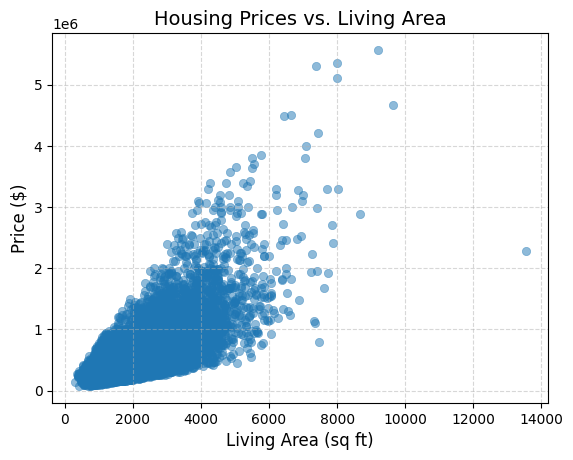

In [6]:
#make any graphs in separate code segments from this if you want to, but keep it in this area to avoid messiness - David


top_outliers = housing['price'].nlargest(3).index


housing = housing.drop(top_outliers)
avg_price_per_grade = housing.groupby("grade", as_index=False)["price"].mean()

sns.scatterplot(
    data=housing,
    x='sqft_living',
    y='price',
    alpha=0.5,
    edgecolor=None
)
plt.xlabel("Living Area (sq ft)", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.title("Housing Prices vs. Living Area", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()







<ipython-input-7-ab51cd0fd712>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


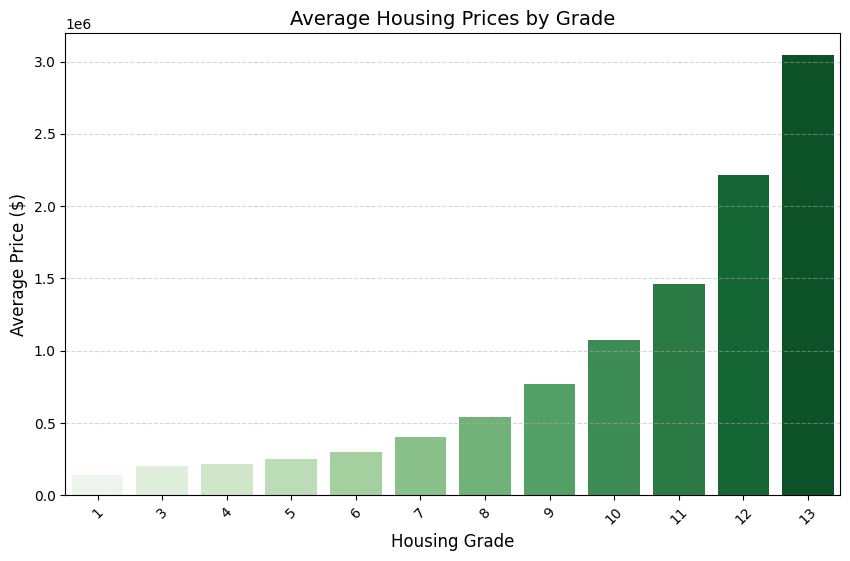

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_price_per_grade,
    x="grade",
    y="price",
    palette="Greens"
)
plt.xlabel("Housing Grade", fontsize=12)
plt.ylabel("Average Price ($)", fontsize=12)
plt.title("Average Housing Prices by Grade", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()

<ipython-input-8-8b4cdd0ce489>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


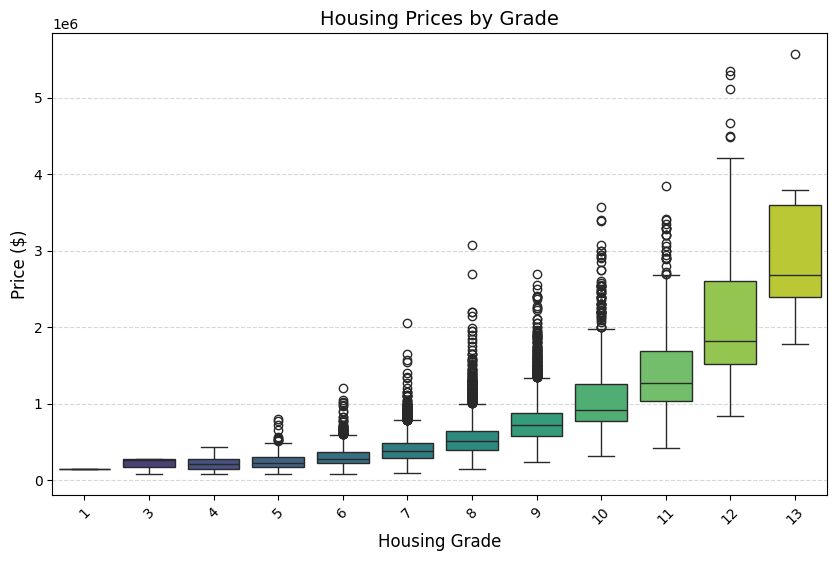

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=housing,
    x='grade',
    y='price',
    palette="viridis",
    showfliers=True,
)
plt.xlabel("Housing Grade", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.title("Housing Prices by Grade", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()

<ipython-input-9-93b4b16d69ec>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


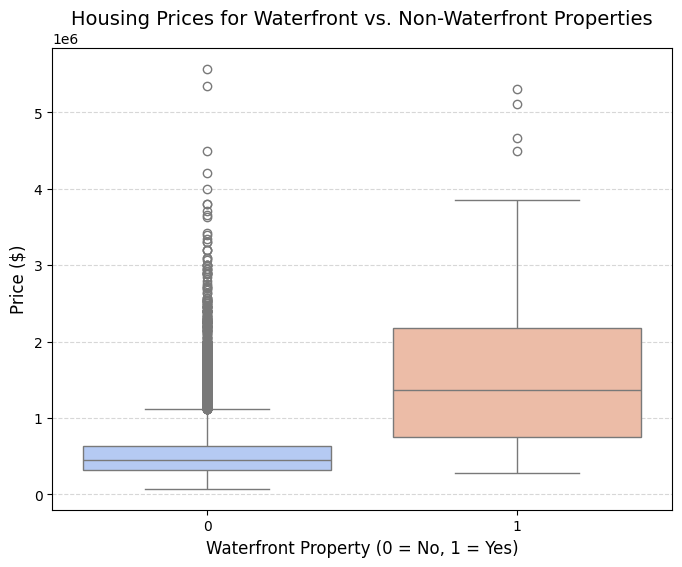

In [9]:
#housing["waterfront"] = housing["waterfront"].astype(str)

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=housing,
    x="waterfront",
    y="price",
    palette="coolwarm",
    showfliers=True
)
plt.xlabel("Waterfront Property (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.title("Housing Prices for Waterfront vs. Non-Waterfront Properties", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [10]:
modifiers = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
}

params = {
    "objective": "reg:squarederror",
    "base_score": 0.5,
    "booster": "gbtree",
    "callbacks": None,
    "colsample_bylevel": 1,
    "colsample_bynode": 1,
    "colsample_bytree": 0.8,
    "early_stopping_rounds": None,
    "enable_categorical": False,
    "eval_metric": "rmse",
    "gamma": 0,
    "gpu_id": -1,
    "grow_policy": "depthwise",
    "importance_type": None,
    "interaction_constraints": "",
    "learning_rate": 0.05,
    "max_bin": 256,
    "max_cat_to_onehot": 4,
    "max_delta_step": 0,
    "max_depth": 7,
    "max_leaves": 0,
    "min_child_weight": 1,
    "missing": np.nan,  # replace NaN with np.nan
    "monotone_constraints": "()",
    "n_estimators": 200,
    "n_jobs": 0,
    "num_parallel_tree": 1,
    "predictor": "auto",
    "random_state": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "sampling_method": "uniform",
    "scale_pos_weight": 1,
    "subsample": 0.8,
    "tree_method": "exact",
    "validate_parameters": 1,
    "verbosity": None,
    "use_label_encoder": False
}



In [11]:



from scipy.stats import randint
import xgboost as xgb



X = housing.drop('price', axis=1, inplace=False)
y = housing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)




weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11,1,1,1,1,1,1,1,1]


weights[3] = 4
weights[9] = 6
weights[17] = 5

# lower = X_train.quantile(0.001)
# upper = X_train.quantile(0.999)

# # Mask rows where all columns are within the quantile bounds
# mask = (X_train >= lower) & (X_train <= upper)

# # Apply the mask to both X_train and y_train (assuming they are DataFrames/Series)
# X_train = X_train[mask.all(axis=1)]
# y_train = y_train[mask.all(axis=1)]

# print(len(X_train))

#one hot encoding









import random
print(random.randint(1,50))
model = XGBRegressor(n_estimators=100,max_depth = 5, max_leaves = 9)

models = RandomizedSearchCV(
    estimator=XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
    param_distributions=modifiers,
    scoring='r2',
    cv=2,
    verbose=2,
    n_jobs=-1,
    n_iter = 20
)





models = models.fit(X_train, y_train)

r_score = models.best_score_
model = models.best_estimator_


best_params = models.best_params_
param_distributions_narrowed = {'n_estimators': randint(best_params['n_estimators']-50, best_params['n_estimators']+50),
                                'max_depth': randint(best_params['max_depth']-2, best_params['max_depth']+2)}

# Second search around best params
# models = RandomizedSearchCV(
#     estimator=XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
#     param_distributions=param_distributions_narrowed,
#     scoring='r2',
#     cv=2,
#     verbose=2,
#     n_jobs=-1,
#     n_iter = 20
# )
# models.fit(X_train, y_train)
# r_score = models.best_score_
# print(r_score)


# best_params = models.best_params_
# param_distributions_narrowed = {'n_estimators': randint(best_params['n_estimators']-5, best_params['n_estimators']+5),
#                                 'max_depth': randint(best_params['max_depth']-1, best_params['max_depth']+1)}

# #Third search around best params
# models = RandomizedSearchCV(
#     estimator=XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
#     param_distributions=param_distributions_narrowed,
#     scoring='r2',
#     cv=2,
#     verbose=2,
#     n_jobs=-1,
#     n_iter = 20
# )
# models.fit(X_train, y_train)


predictions = models.predict(X_test)

r_score2 = r2_score(y_test,predictions)





#model = models.best_estimator_

dtrain = xgb.DMatrix(X_train, label=y_train, feature_weights=weights)
dtest = xgb.DMatrix(X_test, label=y_test)


# Train model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict
predictions = bst.predict(dtest)
model = bst

r_score = r2_score(y_test, predictions)
print(r_score2)
print(r_score)


if r_score < r_score2:
  r_score = r_score2
  model = models

49
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


[22:47:17] WARNING: ../src/learner.cc:627: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9024351326426863
0.9000313053961373


In [12]:
#This gives which features are most important
importances = model.best_estimator_.feature_importances_
# create a dataframe with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # assuming X_train is a pandas dataframe
    'Importance': importances
})

# sort by importance (optional)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                   Feature  Importance
21     grade x sqft_living    0.323993
6                    grade    0.154091
4               waterfront    0.108646
26                  view_4    0.060694
2              sqft_living    0.058143
12                     lat    0.051594
22                  view_0    0.034598
13                    long    0.032197
9                 yr_built    0.019790
14           sqft_living15    0.016964
11                 zipcode    0.012574
24                  view_2    0.010436
7               sqft_above    0.009870
25                  view_3    0.009022
10            yr_renovated    0.007495
30                view_2.5    0.007425
20          sqft per floor    0.006609
16     latest_construction    0.006495
5                condition    0.006402
19   bedrooms_per_bathroom    0.006347
31                view_3.0    0.006277
17  sqft_living_difference    0.005942
29                view_2.0    0.005930
15              sqft_lot15    0.005523
3                 sqft_lo

In [13]:
predictions = model.predict(X_test)

r_score = r2_score(y_test, predictions)

print(r_score)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

0.9024351326426863
RMSE: 109317.94078057302


In [14]:
import json
from google.colab import files
#Download parameters for current model:
params = model.best_estimator_.get_params()


with open("model_params " + str(r_score) + ".json", "w") as f:
    json.dump(params, f)


files.download("model_params " + str(r_score) + ".json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
processed = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

In [16]:






housing = processed
housing["date"] = pd.to_datetime(housing["date"]).dt.strftime("%Y%m%d")
housing['date'] = pd.to_numeric(housing.date)
housing.drop('id',axis=1,inplace=True)
housing['latest_construction'] = housing[['yr_built','yr_renovated']].max(axis=1)
housing.drop('date',axis=1,inplace=True)
housing['sqft_living_difference'] = housing['sqft_living15'] - housing['sqft_living']
housing['sqft_lot_difference'] = housing['sqft_lot15'] - housing['sqft_lot']
housing['bedrooms_per_bathroom'] = housing['bedrooms'] / (housing['bathrooms'] + 1)
housing['sqft per floor'] = housing['sqft_living'] / housing['floors']
housing['grade x sqft_living'] = housing['grade'] * housing['sqft_living']
housing.info()
print(housing.describe())
print(housing.isnull().sum())

view_encoded = pd.get_dummies(housing['view'], prefix='view')


housing = pd.concat([housing, view_encoded], axis=1)


housing.drop('view', axis=1, inplace=True)

floors_encoded = pd.get_dummies(housing['floors'], prefix='view')


housing = pd.concat([housing, floors_encoded], axis=1)


housing.drop('floors', axis=1, inplace=True)
processed = housing







predictions = model.predict(processed)
df = pd.DataFrame()
df['price'] = pd.DataFrame(predictions)
df = df[['price']]

from google.colab import files
df.to_csv('team3-module3-predictions' + str(r_score) + '.csv', index=False)
files.download('team3-module3-predictions' + str(r_score) + '.csv')

print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613 entries, 0 to 1612
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bedrooms                1613 non-null   int64  
 1   bathrooms               1613 non-null   float64
 2   sqft_living             1613 non-null   int64  
 3   sqft_lot                1613 non-null   int64  
 4   floors                  1613 non-null   float64
 5   waterfront              1613 non-null   int64  
 6   view                    1613 non-null   int64  
 7   condition               1613 non-null   int64  
 8   grade                   1613 non-null   int64  
 9   sqft_above              1613 non-null   int64  
 10  sqft_basement           1613 non-null   int64  
 11  yr_built                1613 non-null   int64  
 12  yr_renovated            1613 non-null   int64  
 13  zipcode                 1613 non-null   int64  
 14  lat                     1613 non-null   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1613, 1)
